# FITS processing with fitsbolt
This notebook demonstrates how to create and process multi-extension FITS files using the FitsBolt package. We'll:

1. Create 10 temporary FITS files with 4 extensions each
2. Read these files using `read_images` with `read_only=True` for manual processing
3. Resize the images with `resize_images` (recommended as float32 for processing chain)
4. Apply channel combination with `batch_channel_combination` 
5. Apply normalisation with `normalise_images`

This tutorial demonstrates the updated processing order: **read → resize → combine → normalise**, which is the recommended workflow for optimal image quality and processing efficiency.

This tutorial is particularly useful for astronomical data processing where different wavelengths or observation types are stored in separate extensions within a FITS file.

## 1. Import Required Libraries

First, let's import the necessary libraries for our demonstration:

In [1]:
# Standard libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from time import time
import tempfile
import shutil
from pathlib import Path

# Astropy for FITS handling
from astropy.io import fits

# Import fitsbolt modules
from fitsbolt.read import read_images
from fitsbolt.normalisation.normalisation import normalise_images
from fitsbolt.normalisation.NormalisationMethod import NormalisationMethod
from fitsbolt.resize import resize_image, resize_images
from fitsbolt.channel_mixing import batch_channel_combination

# For visualization
from matplotlib.colors import LogNorm
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)
plt.style.use('dark_background')  # Astronomy images often look better on dark backgrounds

In [2]:
# Helper function for displaying images
def display_images(images, titles=None, cmaps=None, figsize=(16, 8), rows=1):
    """Display multiple images side by side
    
    Args:
        images: List of image arrays to display
        titles: List of titles for each image
        cmaps: List of colormaps to use for each image (or single colormap for all)
        figsize: Figure size
        rows: Number of rows for the subplots
    """
    n = len(images)
    cols = (n + rows - 1) // rows
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    elif rows == 1 or cols == 1:
        axes = axes.flatten()
    
    if titles is None:
        titles = [f"Image {i+1}" for i in range(n)]
    
    if cmaps is None:
        cmaps = ['viridis'] * n
    elif isinstance(cmaps, str):
        cmaps = [cmaps] * n
        
    for i in range(n):
        if i < len(axes):
            if images[i].ndim == 3 and images[i].shape[2] == 3:
                # RGB image
                im = axes[i].imshow(images[i])
            else:
                # Grayscale image
                im = axes[i].imshow(images[i], cmap=cmaps[i])
            axes[i].set_title(titles[i])
            axes[i].axis('off')
            plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
    
    # Hide empty subplots
    for i in range(n, len(axes)):
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()

## 2. Create Temporary Multi-Extension FITS Files

Let's create 10 temporary FITS files, each with 4 extensions. These extensions will simulate different wavelength observations that we'll later map to RGB channels.

In [3]:
# Create a temporary directory for our FITS files
temp_dir = os.path.join(tempfile.gettempdir(), 'fitsbolt_demo')
if os.path.exists(temp_dir):
    shutil.rmtree(temp_dir)  # Clean up any previous runs
os.makedirs(temp_dir)
print(f"Created temporary directory: {temp_dir}")

# Function to create a multi-extension FITS file
def create_multi_extension_fits(filename, size=(256, 256), num_extensions=4):
    """
    Create a FITS file with multiple extensions for testing.
    
    Args:
        filename: Output filename
        size: Image size as (height, width)
        num_extensions: Number of extensions to create
    
    Returns:
        str: Path to the created file
    """
    # Create primary HDU (usually empty in FITS files)
    primary_hdu = fits.PrimaryHDU()
    
    # Add information to the primary header
    primary_hdu.header['OBSERVER'] = 'FitsBolt User'
    primary_hdu.header['OBJECT'] = f'Test Object {Path(filename).stem}'
    primary_hdu.header['DATE-OBS'] = '2025-07-29T00:00:00'
    
    # Create a list to hold all HDUs
    hdus = [primary_hdu]
    
    # Define extension names (common in astronomical data)
    extension_names = ['H_ALPHA', 'O_III', 'S_II', 'LUMINANCE']
    
    # Create data for each extension with different patterns
    center_y, center_x = size[0]//2, size[1]//2
    y, x = np.ogrid[:size[0], :size[1]]
    r = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    theta = np.arctan2(y - center_y, x - center_x)
    
    for i in range(num_extensions):
        # Create different patterns for each extension
        if i == 0:  # H-alpha (typically red in narrowband imaging)
            # Filamentary structure with spiral pattern
            data = np.exp(-(r/200)**2) * 1000 * (1 + 0.5*np.sin(theta*6 + r/20))
            data += np.random.normal(0, 10, size)
        elif i == 1:  # O-III (typically green/blue in narrowband imaging)
            # Bubble-like structure
            data = np.exp(-((r-80)/40)**2) * 1200
            data += np.random.normal(0, 12, size)
        elif i == 2:  # S-II (typically orange/red in narrowband imaging)
            # Clumpy structure
            data = np.zeros(size)
            for j in range(15):
                cx, cy = np.random.randint(0, size[0]), np.random.randint(0, size[1])
                cloud_r = np.sqrt((x - cx)**2 + (y - cy)**2)
                data += np.exp(-cloud_r/30) * np.random.uniform(800, 1200)
            data += np.random.normal(0, 8, size)
        else:  # Luminance (broadband)
            # Overall structure with more detail
            spiral = np.sin(r/15 - theta*3) + 1
            data = spiral * np.exp(-(r/250)**2) * 1500
            data += np.random.normal(0, 15, size)
        
        # Add some bright point sources (stars)
        stars = np.random.exponential(1, size) * (np.random.rand(*size) > 0.996) * 6000
        data += stars
        
        # Ensure no negative values
        data = np.clip(data, 0, None)
        
        # Create the image HDU
        image_hdu = fits.ImageHDU(data.astype(np.float32))
        
        # Set extension name
        if i < len(extension_names):
            image_hdu.header['EXTNAME'] = extension_names[i]
        else:
            image_hdu.header['EXTNAME'] = f'EXT{i+1}'
            
        # Add metadata specific to each extension
        image_hdu.header['FILTER'] = extension_names[i] if i < len(extension_names) else f'FILTER{i+1}'
        image_hdu.header['EXPTIME'] = np.random.uniform(100, 1000)  # Exposure time in seconds
        image_hdu.header['GAIN'] = np.random.uniform(1.0, 2.5)      # Detector gain
        
        # Add to HDU list
        hdus.append(image_hdu)
    
    # Create HDU list and write to file
    hdul = fits.HDUList(hdus)
    hdul.writeto(filename, overwrite=True)
    
    return filename

# Create 10 FITS files with 4 extensions each
fits_files = []
for i in range(10):
    filename = os.path.join(temp_dir, f"multi_ext_{i+1:02d}.fits")
    create_multi_extension_fits(filename, size=(256, 256), num_extensions=4)
    fits_files.append(filename)

print(f"Created {len(fits_files)} FITS files with 4 extensions each in '{temp_dir}'")

# Check the structure of the first file
with fits.open(fits_files[0]) as hdul:
    print(f"\nStructure of {os.path.basename(fits_files[0])}:")
    print(f"Number of HDUs: {len(hdul)}")
    for i, hdu in enumerate(hdul):
        if i == 0:
            print(f"  HDU {i}: Primary (no data)")
        else:
            print(f"  HDU {i}: {hdu.header.get('EXTNAME', f'Extension {i}')} - "
                  f"Shape: {hdu.data.shape}, Type: {hdu.data.dtype}")
            print(f"     FILTER: {hdu.header.get('FILTER', 'N/A')}, "
                  f"EXPTIME: {hdu.header.get('EXPTIME', 'N/A'):.1f}s")

Created temporary directory: C:\Users\laslo\AppData\Local\Temp\fitsbolt_demo
Created 10 FITS files with 4 extensions each in 'C:\Users\laslo\AppData\Local\Temp\fitsbolt_demo'

Structure of multi_ext_01.fits:
Number of HDUs: 5
  HDU 0: Primary (no data)
  HDU 1: H_ALPHA - Shape: (256, 256), Type: >f4
     FILTER: H_ALPHA, EXPTIME: 483.4s
  HDU 2: O_III - Shape: (256, 256), Type: >f4
     FILTER: O_III, EXPTIME: 709.3s
  HDU 3: S_II - Shape: (256, 256), Type: >f4
     FILTER: S_II, EXPTIME: 522.9s
  HDU 4: LUMINANCE - Shape: (256, 256), Type: >f4
     FILTER: LUMINANCE, EXPTIME: 818.0s
Created 10 FITS files with 4 extensions each in 'C:\Users\laslo\AppData\Local\Temp\fitsbolt_demo'

Structure of multi_ext_01.fits:
Number of HDUs: 5
  HDU 0: Primary (no data)
  HDU 1: H_ALPHA - Shape: (256, 256), Type: >f4
     FILTER: H_ALPHA, EXPTIME: 483.4s
  HDU 2: O_III - Shape: (256, 256), Type: >f4
     FILTER: O_III, EXPTIME: 709.3s
  HDU 3: S_II - Shape: (256, 256), Type: >f4
     FILTER: S_II, E

### 2.1 Visualize the Raw FITS Extensions

Let's examine the individual extensions of one of our FITS files to understand what data we'll be working with:

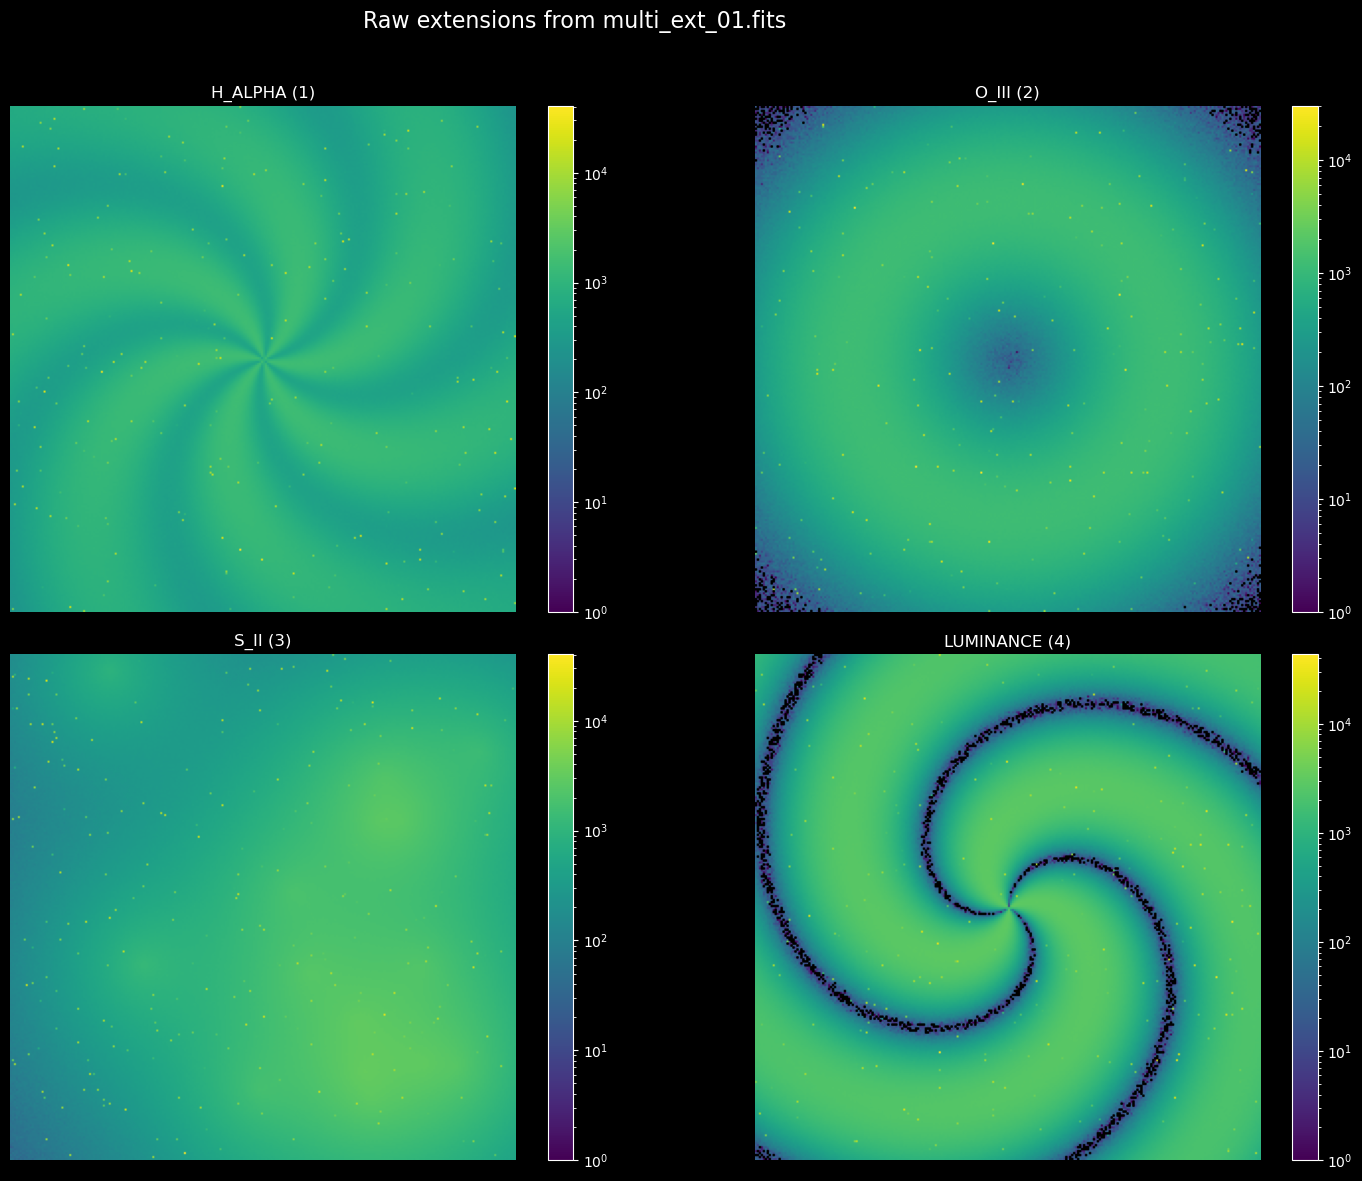

In [4]:
# Load the extensions individually using astropy.io.fits directly for visualization
sample_file = fits_files[0]

with fits.open(sample_file) as hdul:
    # Skip the primary HDU (index 0) which has no data
    extension_data = []
    extension_names = []
    
    for i in range(1, len(hdul)):
        ext = hdul[i]
        extension_data.append(ext.data)
        extension_names.append(f"{ext.header.get('EXTNAME', f'Extension {i}')} ({i})")
    
    # Visualize each extension
    plt.figure(figsize=(16, 12))
    for i, (data, name) in enumerate(zip(extension_data, extension_names)):
        plt.subplot(2, 2, i+1)
        
        # Use log normalisation for better visibility of astronomical data
        im = plt.imshow(data, cmap='viridis', norm=LogNorm(vmin=1, vmax=data.max()))
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.title(name)
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(f"Raw extensions from {os.path.basename(sample_file)}", fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()

## 4. Reading Multi-Extension FITS Files with FitsBolt

Now that we've compared the workflows, let's dive deeper into the manual processing approach and explore different extension mapping strategies.

## 3. Automated vs Manual Processing Workflows

FitsBolt now supports both automated and manual processing workflows. Let's compare both approaches to understand when to use each one.

### 3.1 Automated Workflow (Traditional)

The traditional approach uses `load_and_process_images` which handles everything automatically:

```python
# Single function call - everything automated
result = load_and_process_images(
    filepaths=[sample_file],
    fits_extension=[1, 2, 3],
    size=[256, 256],
    normalisation_method=NormalisationMethod.ASINH
)
```

**Pros**: Simple, quick for standard workflows  
**Cons**: Less control over intermediate steps, harder to debug, limited customization

### 3.2 Manual Workflow (New & Recommended)

The new manual approach gives you control over each step:

```python
# Step-by-step processing with full control
raw = read_images(filepaths, fits_extension=[1,2,3], read_only=True)
resized = resize_images(raw, size=[256,256], output_dtype=np.float32)  
combined = batch_channel_combination(resized, channel_mapping)
normalised = normalise_images(combined, method=NormalisationMethod.ASINH)
```

**Pros**: Full control, better debugging, custom data types, optimal quality  
**Cons**: More verbose, requires understanding of each step

Let's demonstrate both approaches:

=== AUTOMATED WORKFLOW ===
Created channel_combination array with shape (3, 3)
Array contents: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Automated workflow completed in 0.039 seconds
Result shape: (256, 256, 3), dtype: uint8

=== MANUAL WORKFLOW ===
Created channel_combination array with shape (3, 3)
Array contents: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Manual workflow completed in 0.034 seconds
Result shape: (256, 256, 3), dtype: uint8


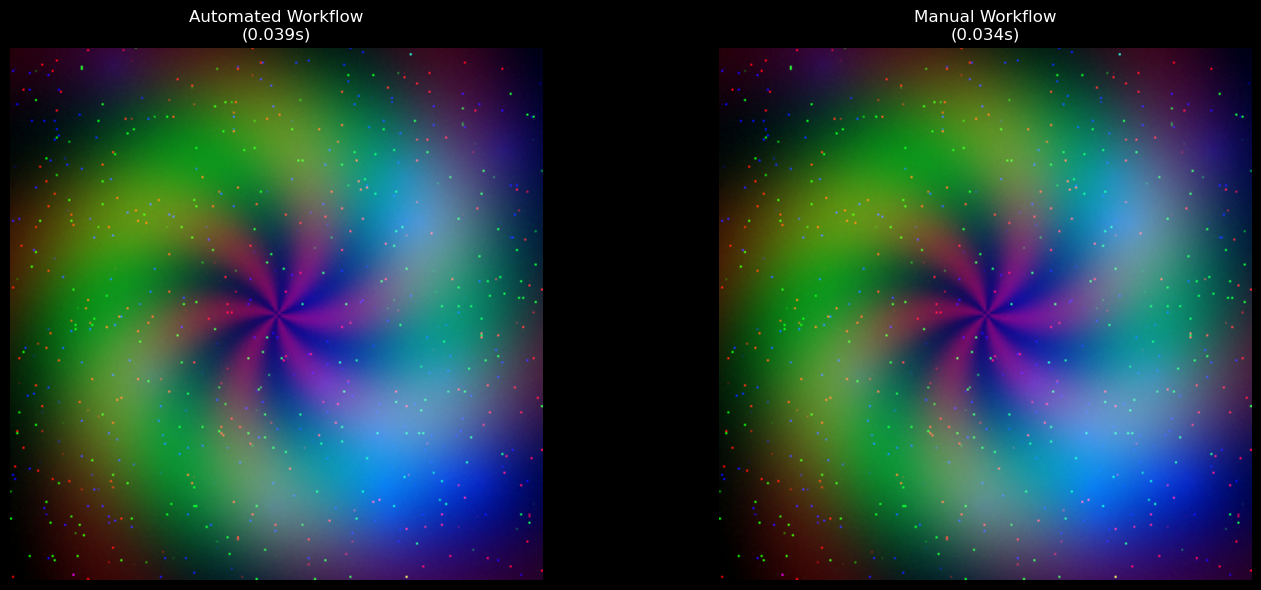

In [5]:
# Compare Automated vs Manual Workflows
sample_file = fits_files[0]

print("=== AUTOMATED WORKFLOW ===")
start_time = time()

# Automated approach - single function call
from fitsbolt import load_and_process_images
automated_result = load_and_process_images(
    filepaths=[sample_file],
    fits_extension=[1, 2, 3],  # H_ALPHA, O_III, S_II
    size=[256, 256],
    normalisation_method=NormalisationMethod.ASINH,
    norm_asinh_scale=[0.7, 0.7, 0.7],
    norm_asinh_clip=[99.5, 99.5, 99.5],
    n_output_channels=3,
    show_progress=False
)[0]

automated_time = time() - start_time
print(f"Automated workflow completed in {automated_time:.3f} seconds")
print(f"Result shape: {automated_result.shape}, dtype: {automated_result.dtype}")

print("\n=== MANUAL WORKFLOW ===")
start_time = time()

# Manual approach - step by step with new order
# Step 1: Read
manual_raw = read_images(
    sample_file,
    fits_extension=[1, 2, 3],
    read_only=True,
    show_progress=False
)

# Step 2: Resize
manual_resized = resize_images(
    [manual_raw],
    size=[256, 256],
    output_dtype=np.float32,
    show_progress=False
)[0]

# Step 3: Combine channels (identity mapping for fair comparison)
identity_mapping = np.eye(3)
batch_input = np.expand_dims(manual_resized, axis=0)
manual_combined = batch_channel_combination(
    batch_input,
    identity_mapping,
    output_dtype=None  # Keep as float for normalisation
)
manual_combined = np.squeeze(manual_combined, axis=0)

# Step 4: Normalise
manual_normalised = normalise_images(
    [manual_combined],
    normalisation_method=NormalisationMethod.ASINH,
    norm_asinh_scale=[0.7, 0.7, 0.7],
    norm_asinh_clip=[99.5, 99.5, 99.5],
    output_dtype=np.uint8,
    show_progress=False
)[0]

manual_time = time() - start_time
print(f"Manual workflow completed in {manual_time:.3f} seconds")
print(f"Result shape: {manual_normalised.shape}, dtype: {manual_normalised.dtype}")

# Visual comparison
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(automated_result)
plt.title(f"Automated Workflow\n({automated_time:.3f}s)")
plt.axis('off')

plt.subplot(1, 2, 2) 
plt.imshow(manual_normalised)
plt.title(f"Manual Workflow\n({manual_time:.3f}s)")
plt.axis('off')

plt.tight_layout()
plt.show()

### 4.1 Manual Processing with the New Workflow

We'll demonstrate the updated processing workflow using the manual approach:

1. **Read with `read_only=True`**: Load extensions without automatic channel combination
2. **Resize as float32**: Better for processing chain
3. **Combine**: Use `batch_channel_combination` for custom mapping
4. **Normalize**: Apply stretching methods as final step

This approach gives you full control over each step and is recommended for complex processing workflows.

Created channel_combination array with shape (3, 3)
Array contents: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Raw extensions shape: (256, 256, 3)
Data type: float32
Value range: [0.0, 40628.8]
Resized shape: (256, 256, 3)
Resized dtype: float32
Combined shape: (256, 256, 3)
Combined dtype: float64
Final result shape: (256, 256, 3)
Final dtype: uint8


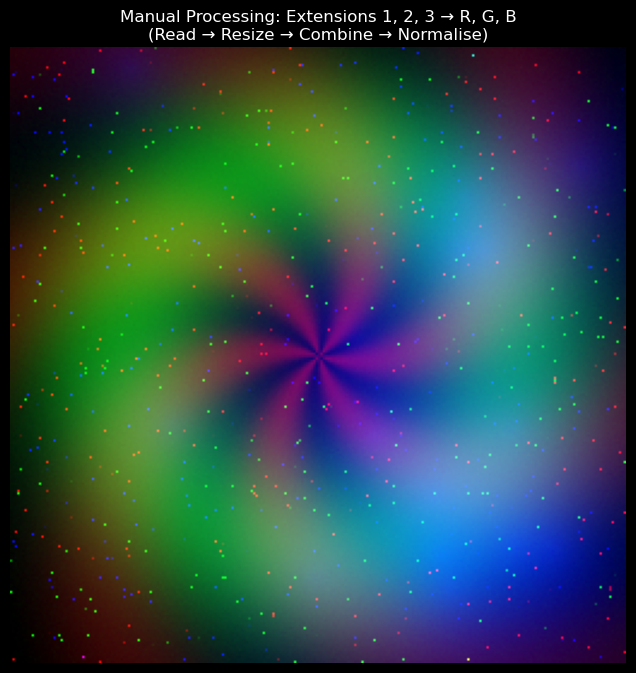

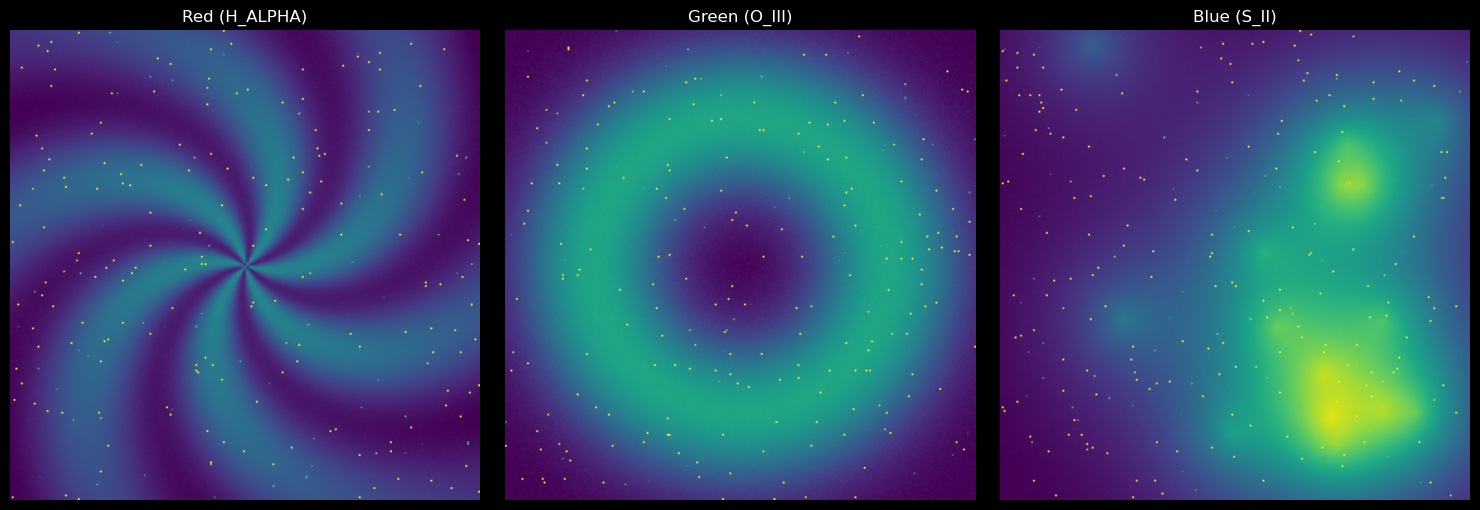

In [9]:
# Manual Processing Workflow - Step 1: Read with read_only=True
sample_file = fits_files[0]

# Read extensions without automatic channel combination
raw_extensions = read_images(
    sample_file,
    fits_extension=[1, 2, 3],  # H_ALPHA, O_III, S_II
    read_only=True,            # Skip automatic channel combination
    show_progress=False
)

print(f"Raw extensions shape: {raw_extensions.shape}")
print(f"Data type: {raw_extensions.dtype}")
print(f"Value range: [{raw_extensions.min():.1f}, {raw_extensions.max():.1f}]")

# Step 2: Resize as float32 (recommended for processing)
resized_extensions = resize_images(
    [raw_extensions],
    size=[256, 256],
    output_dtype=np.float32,   # Better for processing chain
    show_progress=False
)[0]

print(f"Resized shape: {resized_extensions.shape}")
print(f"Resized dtype: {resized_extensions.dtype}")

# Step 3: Apply channel combination using batch_channel_combination
# Direct mapping: extensions 1, 2, 3 → R, G, B channels
channel_mapping = np.eye(3)  # Identity matrix for 1:1 mapping

# batch_channel_combination expects shape (N, H, W, C)
batch_input = np.expand_dims(resized_extensions, axis=0)
combined_extensions = batch_channel_combination(
    batch_input,
    channel_mapping,
    output_dtype=None  # Keep as float for normalisation
)
# Remove batch dimension
combined_extensions = np.squeeze(combined_extensions, axis=0)

print(f"Combined shape: {combined_extensions.shape}")
print(f"Combined dtype: {combined_extensions.dtype}")

# Step 4: Normalize after channel combination
normalised_extensions = normalise_images(
    [combined_extensions],
    normalisation_method=NormalisationMethod.ASINH,
    norm_asinh_scale=[0.7, 0.7, 0.7],
    norm_asinh_clip=[99.5, 99.5, 99.5],
    output_dtype=np.uint8,
    show_progress=False
)[0]

print(f"Final result shape: {normalised_extensions.shape}")
print(f"Final dtype: {normalised_extensions.dtype}")

# Display the result
plt.figure(figsize=(10, 8))
plt.imshow(normalised_extensions)
plt.title("Manual Processing: Extensions 1, 2, 3 → R, G, B\n(Read → Resize → Combine → Normalise)")
plt.axis('off')
plt.show()

# Display individual channels
plt.figure(figsize=(15, 5))
channel_names = ['Red (H_ALPHA)', 'Green (O_III)', 'Blue (S_II)']
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(normalised_extensions[:,:,i], cmap='viridis')
    plt.title(channel_names[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

### 4.2 Custom Channel Combination with Manual Processing

Now let's demonstrate a more complex custom mapping using the manual workflow. We'll create a custom mapping matrix and use `batch_channel_combination` to combine extensions with custom weights.

Custom mapping example:
- Red channel: 70% H-alpha + 30% S-II
- Green channel: 80% O-III + 20% Luminance
- Blue channel: 60% O-III + 40% S-II

This approach is similar to the "Hubble palette" used in astrophotography.

Created channel_combination array with shape (4, 4)
Array contents: [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Raw all extensions shape: (256, 256, 4)
Custom channel mapping matrix:
[[0.7 0.  0.3 0. ]
 [0.  0.8 0.  0.2]
 [0.  0.6 0.4 0. ]]
Custom combined shape: (256, 256, 3)
Custom combined dtype: float64
Custom mapping result shape: (256, 256, 3)
Data type: uint8


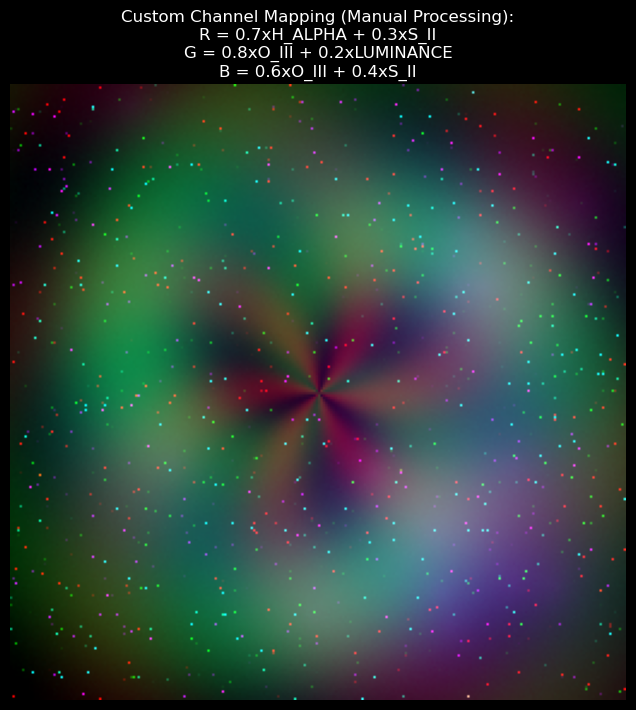

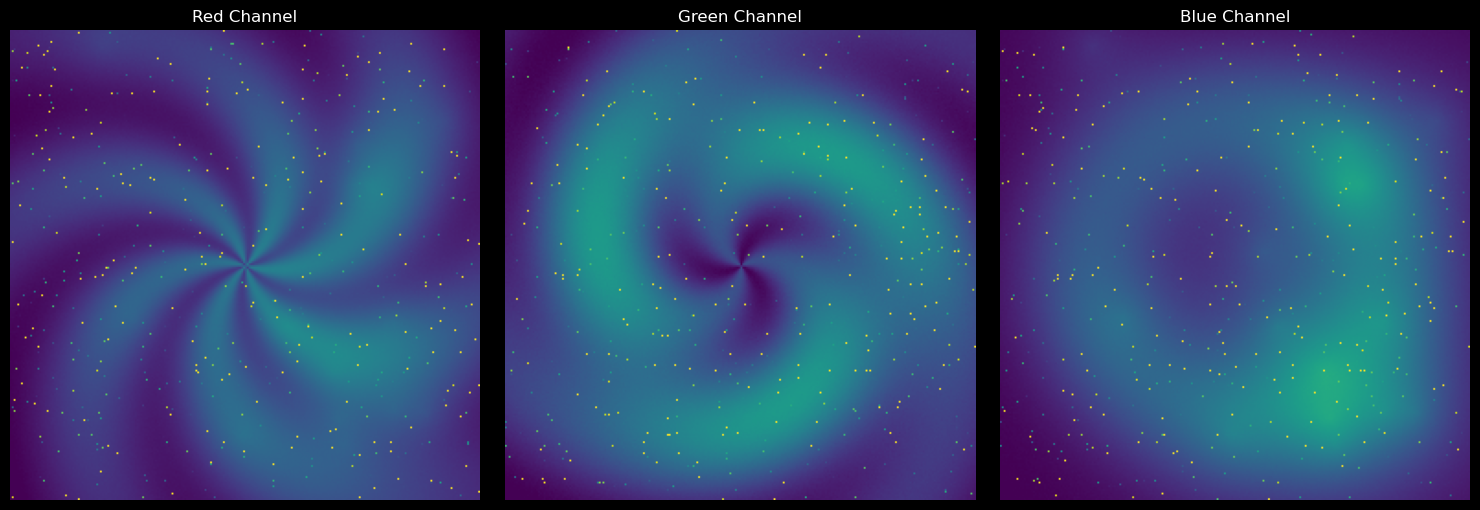

In [10]:
# Custom Channel Combination with Manual Processing

# Step 1: Read all 4 extensions without automatic combination
raw_all_extensions = read_images(
    sample_file,
    fits_extension=[1, 2, 3, 4],  # H_ALPHA, O_III, S_II, LUMINANCE
    read_only=True,               # Skip automatic channel combination
    show_progress=False
)

print(f"Raw all extensions shape: {raw_all_extensions.shape}")

# Step 2: Resize as float32
resized_all = resize_images(
    [raw_all_extensions],
    size=[256, 256],
    output_dtype=np.float32,
    show_progress=False
)[0]

# Step 3: Define custom channel mapping and apply before normalisation
# R = 0.7*H_ALPHA (ext1) + 0.3*S_II (ext3)
# G = 0.8*O_III (ext2) + 0.2*LUMINANCE (ext4)
# B = 0.6*O_III (ext2) + 0.4*S_II (ext3)
custom_channel_mapping = np.array([
    [0.7, 0.0, 0.3, 0.0],  # R channel
    [0.0, 0.8, 0.0, 0.2],  # G channel
    [0.0, 0.6, 0.4, 0.0]   # B channel
])

print("Custom channel mapping matrix:")
print(custom_channel_mapping)

# Apply custom channel combination before normalisation
batch_input = np.expand_dims(resized_all, axis=0)
custom_combined = batch_channel_combination(
    batch_input,
    custom_channel_mapping,
    output_dtype=None,  # Keep as float for normalisation
)
custom_combined = np.squeeze(custom_combined, axis=0)

print(f"Custom combined shape: {custom_combined.shape}")
print(f"Custom combined dtype: {custom_combined.dtype}")

# Step 4: Normalize after channel combination
custom_normalised = normalise_images(
    [custom_combined],
    normalisation_method=NormalisationMethod.ASINH,
    norm_asinh_scale=[0.7, 0.7, 0.7],
    norm_asinh_clip=[99.5, 99.5, 99.5],
    output_dtype=np.uint8,
    show_progress=False
)[0]

print(f"Custom mapping result shape: {custom_normalised.shape}")
print(f"Data type: {custom_normalised.dtype}")

# Display the result
plt.figure(figsize=(10, 8))
plt.imshow(custom_normalised)
plt.title("Custom Channel Mapping (Manual Processing):\nR = 0.7xH_ALPHA + 0.3xS_II\nG = 0.8xO_III + 0.2xLUMINANCE\nB = 0.6xO_III + 0.4xS_II")
plt.axis('off')
plt.show()

# Display individual channels
plt.figure(figsize=(15, 5))
channel_names = ['Red Channel', 'Green Channel', 'Blue Channel']
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(custom_normalised[:,:,i], cmap='viridis')
    plt.title(channel_names[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

### 4.3 Single Extension Processing

For our third approach, we'll process a single extension (the Luminance channel) through the manual workflow and then replicate it to all three RGB channels for a grayscale image with RGB structure.

Created channel_combination array with shape (1, 1)
Array contents: [[1.]]
Raw luminance shape: (256, 256, 1)
Luminance RGB shape: (256, 256, 3)
Data type: uint8


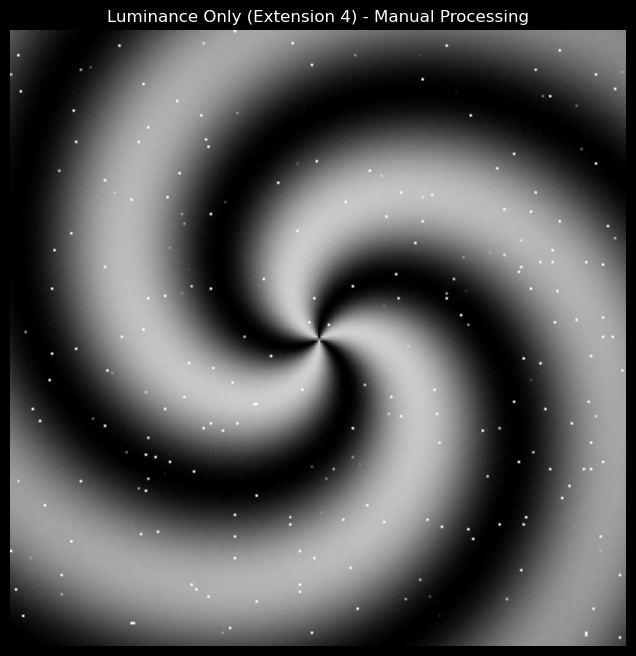

In [13]:
# Single Extension Processing with Manual Workflow

# Step 1: Read only the Luminance extension
raw_luminance = read_images(
    sample_file,
    fits_extension=4,     # Use only the Luminance extension
    read_only=True,       # Skip automatic channel combination
    show_progress=False
)

print(f"Raw luminance shape: {raw_luminance.shape}")

# Step 2: Resize as float32
resized_luminance = resize_images(
    [raw_luminance],
    size=[256, 256],
    output_dtype=np.float32,
    show_progress=False
)[0]

# Step 3: normalise
normalised_luminance = normalise_images(
    [resized_luminance],
    normalisation_method=NormalisationMethod.ASINH,
    norm_asinh_scale=[0.7],  # Single channel
    norm_asinh_clip=[99.5],
    output_dtype=np.uint8,
    show_progress=False
)[0]

# Step 4: Create RGB image by replicating the luminance channel
# For single channel to RGB, we can use a simple approach or batch_channel_combination
if len(normalised_luminance.shape) == 2:
    # If it's 2D, expand to have a channel dimension
    normalised_luminance = np.expand_dims(normalised_luminance, axis=-1)

# Method 1: Simple replication
luminance_rgb_simple = np.repeat(normalised_luminance, 3, axis=-1)

# Method 2: Using batch_channel_combination for consistency
# Define mapping: single channel to all RGB channels
luminance_mapping = np.array([
    [1.0],  # R = 100% luminance
    [1.0],  # G = 100% luminance  
    [1.0]   # B = 100% luminance
])

batch_input = np.expand_dims(normalised_luminance, axis=0)
luminance_rgb_batch = batch_channel_combination(
    batch_input,
    luminance_mapping,
    output_dtype=normalised_luminance.dtype,
)
luminance_image = np.squeeze(luminance_rgb_batch, axis=0)

print(f"Luminance RGB shape: {luminance_image.shape}")
print(f"Data type: {luminance_image.dtype}")

# Display the result
plt.figure(figsize=(10, 8))
plt.imshow(luminance_image, cmap='gray')
plt.title("Luminance Only (Extension 4) - Manual Processing")
plt.axis('off')
plt.show()


## 5. Normalizing Multi-Extension Images

Now let's explore different normalisation methods applied after resizing and channel combination, which is the recommended workflow order. We'll demonstrate how the new LINEAR normalisation method compares to other methods.

Created channel_combination array with shape (4, 4)
Array contents: [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


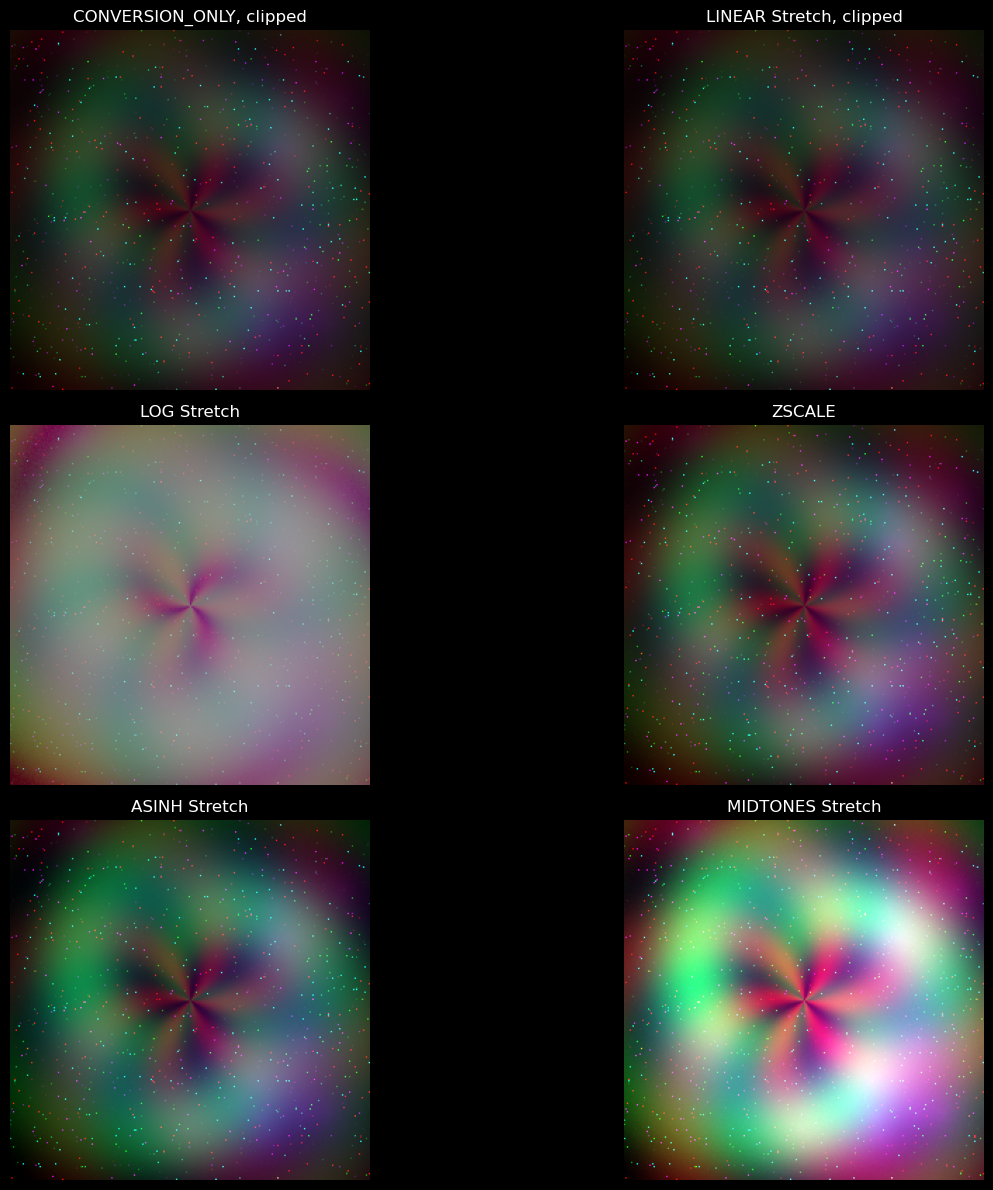

Selected normalised image shape: (256, 256, 3)
Data type: uint8
Value range: [0, 255]


In [20]:
# Let's use our custom-mapped approach and apply different normalisation methods
# Start fresh with the resize → combine → normalise workflow

# Step 1: Read without combination
raw_input = read_images(
    sample_file,
    fits_extension=[1, 2, 3, 4],  # All extensions
    read_only=True,
    show_progress=False
)

# Step 2: Resize as float32 (recommended for processing)
resized_input = resize_images(
    [raw_input],
    size=[256, 256],
    output_dtype=np.float32,
    show_progress=False
)[0]

# Step 3: Apply channel combination before normalisation
custom_channel_mapping = np.array([
    [0.7, 0.0, 0.3, 0.0],  # R channel
    [0.0, 0.8, 0.0, 0.2],  # G channel  
    [0.0, 0.6, 0.4, 0.0]   # B channel
])

batch_input = np.expand_dims(resized_input, axis=0)
combined_input = batch_channel_combination(
    batch_input,
    custom_channel_mapping,
    output_dtype=None  # Keep as float for normalisation
)
combined_input = np.squeeze(combined_input, axis=0)

# Step 4: Apply different normalisation methods to the combined image
norm_images = []
norm_titles = []

# 1. CONVERSION_ONLY - Simple linear stretch for floats
norm_conversion = normalise_images(
    [combined_input], 
    normalisation_method=NormalisationMethod.CONVERSION_ONLY,
    norm_maximum_value=5000, # clips very bright "cosmic rays"
    output_dtype=np.uint8,
    show_progress=False
)[0]
norm_images.append(norm_conversion)
norm_titles.append("CONVERSION_ONLY, clipped")

# 2. LINEAR - New linear stretch method
norm_linear = normalise_images(
    [combined_input], 
    normalisation_method=NormalisationMethod.LINEAR,
    norm_maximum_value=5000, # clips very bright "cosmic rays"
    output_dtype=np.uint8,
    show_progress=False
)[0]
norm_images.append(norm_linear)
norm_titles.append("LINEAR Stretch, clipped")

# 3. LOG stretch - Good for high dynamic range data
norm_log = normalise_images(
    [combined_input], 
    normalisation_method=NormalisationMethod.LOG,
    output_dtype=np.uint8,
    show_progress=False
)[0]
norm_images.append(norm_log)
norm_titles.append("LOG Stretch")

# 4. ZSCALE - Common in astronomy visualization
norm_zscale = normalise_images(
    [combined_input], 
    normalisation_method=NormalisationMethod.ZSCALE,
    output_dtype=np.uint8,
    show_progress=False
)[0]
norm_images.append(norm_zscale)
norm_titles.append("ZSCALE")

# 5. ASINH - Best for preserving both bright and faint details
norm_asinh = normalise_images(
    [combined_input], 
    normalisation_method=NormalisationMethod.ASINH,
    norm_asinh_scale=[0.7, 0.7, 0.7],    # Stretch factor per channel
    norm_asinh_clip=[99.5, 99.5, 99.5],  # Percentile clipping per channel
    output_dtype=np.uint8,
    show_progress=False
)[0]
norm_images.append(norm_asinh)
norm_titles.append("ASINH Stretch")
# 5. MIDTONES - Best for preserving both bright and faint details
norm_midtones = normalise_images(
    [combined_input], 
    normalisation_method=NormalisationMethod.MIDTONES,
    norm_midtones_percentile=99.,    # Percentile clipping per channel
    norm_midtones_desired_mean=0.5,  # Desired mean value (applied after normalising to [0,1])
    output_dtype=np.uint8,
    show_progress=False
)[0]
norm_images.append(norm_midtones)
norm_titles.append("MIDTONES Stretch")



# Display all normalised images for comparison
plt.figure(figsize=(15, 12))
for i, (img, title) in enumerate(zip(norm_images, norm_titles)):
    plt.subplot(3, 2, i+1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Choose the ASINH normalisation for further processing
normalised_image = norm_images[-1]  # ASINH result
print(f"Selected normalised image shape: {normalised_image.shape}")
print(f"Data type: {normalised_image.dtype}")
print(f"Value range: [{normalised_image.min()}, {normalised_image.max()}]")

## 6. Resizing Images

Now let's demonstrate resizing our processed image to different dimensions using different interpolation methods. Note that in the new workflow, we typically resize early in the pipeline (after reading, before combining and normalising) for better quality. Here we'll demonstrate different resizing options on our final result.

Resized to (128, 128), shape: (128, 128, 3)
Resized to (64, 64), shape: (64, 64, 3)
Resized to (512, 512), shape: (512, 512, 3)


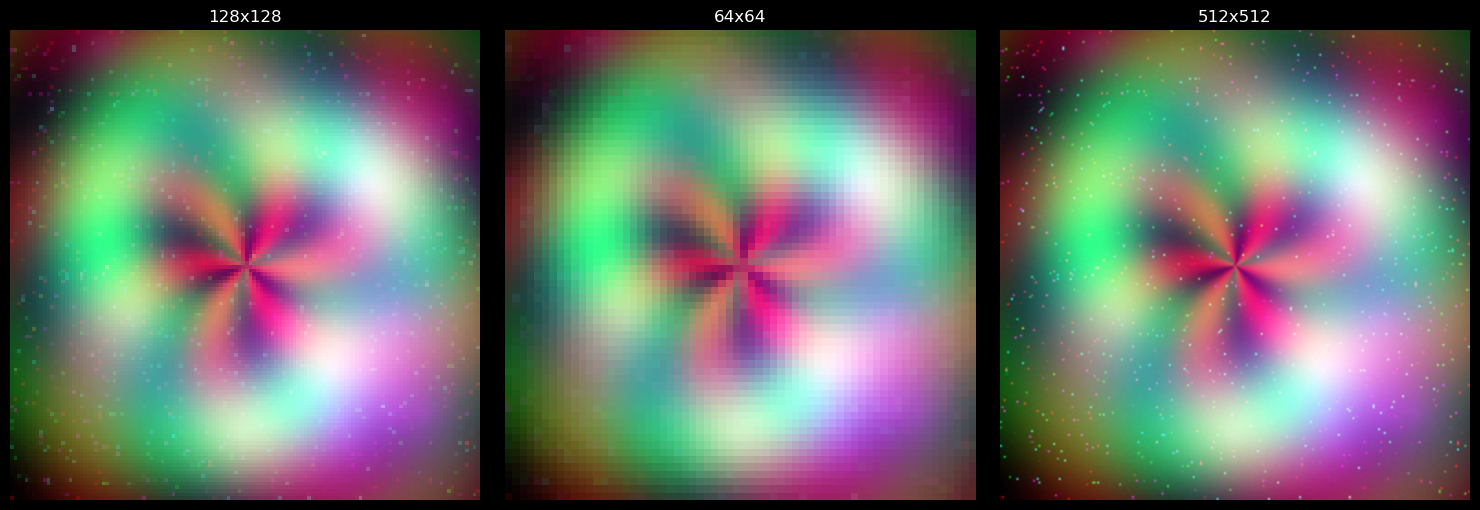

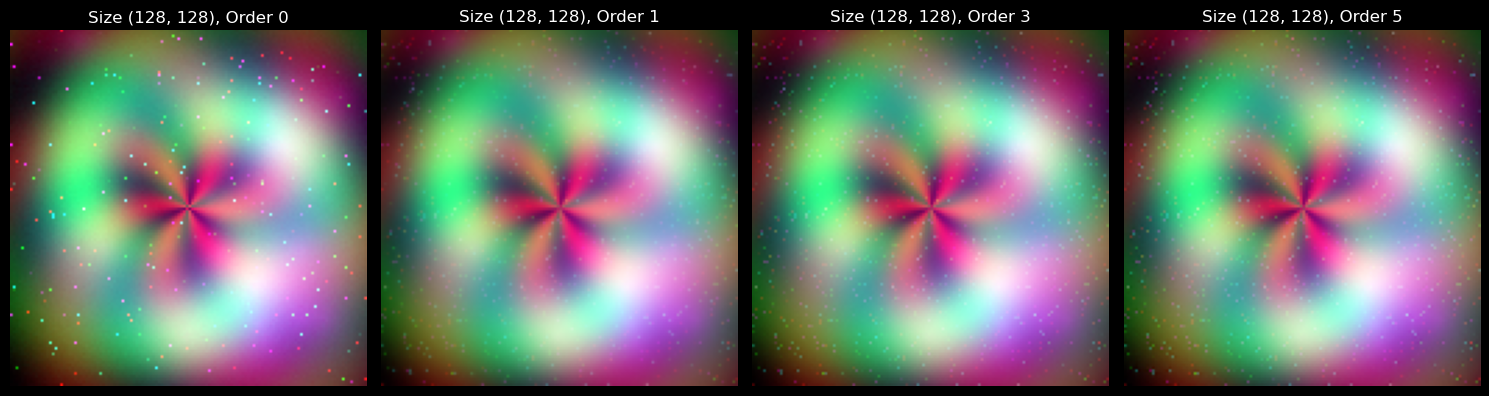

Final resized image shape: (512, 512, 3)
Data type: uint8


In [21]:
# Let's resize to different sizes with different interpolation methods
input_image = normalised_image

# Resize to different sizes
target_sizes = [(128, 128), (64, 64), (512, 512)]
resized_images = []
resized_titles = []

for size in target_sizes:
    # Use default bilinear interpolation (order=1)
    resized = resize_image(
        input_image, 
        size=size, 
        output_dtype=np.uint8
    )
    resized_images.append(resized)
    resized_titles.append(f"{size[0]}x{size[1]}")
    print(f"Resized to {size}, shape: {resized.shape}")

# Display resized images
plt.figure(figsize=(15, 5))
for i, (img, title) in enumerate(zip(resized_images, resized_titles)):
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Try different interpolation methods for one size
size = (128, 128)
interpolation_orders = [0, 1, 3, 5]  # 0=nearest, 1=bilinear, 3=cubic, 5=quintic
interp_images = []
interp_titles = []

for order in interpolation_orders:
    resized = resize_image(
        input_image, 
        size=size, 
        interpolation_order=order,
        output_dtype=np.uint8
    )
    interp_images.append(resized)
    interp_titles.append(f"Order {order}")

# Display resized images with different interpolation orders
plt.figure(figsize=(15, 5))
for i, (img, title) in enumerate(zip(interp_images, interp_titles)):
    plt.subplot(1, 4, i+1)
    plt.imshow(img)
    plt.title(f"Size {size}, {title}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Choose a final resized image for further processing
resized_image = resized_images[2]  # 512x512 version
print(f"Final resized image shape: {resized_image.shape}")
print(f"Data type: {resized_image.dtype}")

## 7. Batch Processing with FitsBolt

Now let's process all of our 10 FITS files using the updated workflow: read (with read_only), resize, combine channels, and normalise. This demonstrates the efficiency of the new manual processing approach.

Processing 10 FITS files with the new workflow...
Step 1: Reading images...
Created channel_combination array with shape (4, 4)
Array contents: [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


Reading images: 100%|██████████| 10/10 [00:00<00:00, 36824.44it/s]



Read 10 multi-extension images in 0.34 seconds
Step 2: Resizing images...


Resizing images: 100%|██████████| 10/10 [00:00<00:00, 140.08it/s]



Resized 10 images to (128, 128) in 0.12 seconds
Step 3: Applying channel combination...
Applied channel combination to 10 images in 0.01 seconds
Step 4: Normalising images...


Normalising images: 100%|██████████| 10/10 [00:00<00:00, 215.00it/s]



Normalised 10 images in 0.15 seconds
Total processing time: 0.62 seconds
Final images shape: (10, 128, 128, 3)


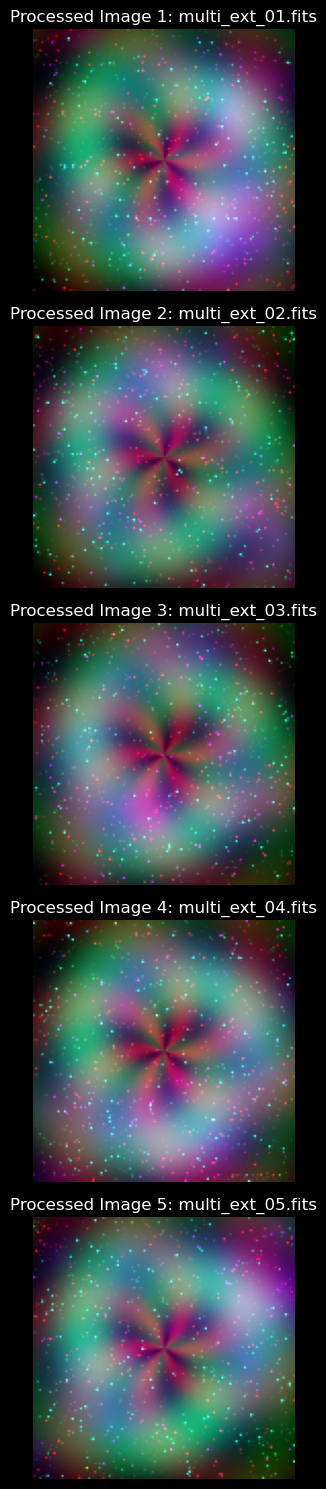

In [22]:
# Batch process all FITS files using the new manual workflow
# Define the mapping that we'll use for all files
channel_mapping = np.array([
    [0.7, 0.0, 0.3, 0.0],  # R channel
    [0.0, 0.8, 0.0, 0.2],  # G channel
    [0.0, 0.6, 0.4, 0.0]   # B channel
])

print(f"Processing {len(fits_files)} FITS files with the new workflow...")

# Step 1: Read all FITS files without automatic channel combination
print("Step 1: Reading images...")
start_time = time()

raw_images = read_images(
    fits_files,
    fits_extension=[1, 2, 3, 4],  # Use all data extensions
    read_only=True,               # Skip automatic channel combination
    num_workers=4,                # Use parallel processing
    show_progress=True
)

read_time = time() - start_time
print(f"Read {len(raw_images)} multi-extension images in {read_time:.2f} seconds")

# Step 2: Resize all images to float32 (recommended for processing chain)
print("Step 2: Resizing images...")
target_size = (128, 128)
start_time = time()

resized_images = resize_images(
    raw_images,
    size=target_size,
    interpolation_order=1,
    output_dtype=np.float32,  # Use float32 for better processing
    num_workers=4,
    show_progress=True
)

resize_time = time() - start_time
print(f"Resized {len(resized_images)} images to {target_size} in {resize_time:.2f} seconds")

# Step 3: Apply channel combination to all images
print("Step 3: Applying channel combination...")
start_time = time()

# batch_channel_combination can process all images at once
combined_images = batch_channel_combination(
    np.array(resized_images),  # Convert list to array (N, H, W, C)
    channel_mapping,
    output_dtype=None,  # Keep as float for normalisation
)

combine_time = time() - start_time
print(f"Applied channel combination to {len(combined_images)} images in {combine_time:.2f} seconds")

# Step 4: Normalise all combined images
print("Step 4: Normalising images...")
start_time = time()

norm_images = normalise_images(
    combined_images,
    normalisation_method=NormalisationMethod.ASINH,
    norm_asinh_scale=[0.7],
    norm_asinh_clip=[99.5],
    output_dtype=np.uint8,  # Final output as uint8
    num_workers=4,
    show_progress=True
)

norm_time = time() - start_time
print(f"Normalised {len(norm_images)} images in {norm_time:.2f} seconds")

print(f"Total processing time: {read_time + resize_time + combine_time + norm_time:.2f} seconds")
print(f"Final images shape: {np.array(norm_images).shape}")

# Display a sample of the results
num_samples = min(5, len(norm_images))
plt.figure(figsize=(15, 3*num_samples))

for i in range(num_samples):
    plt.subplot(num_samples, 1, i+1)
    plt.imshow(norm_images[i])
    plt.title(f"Processed Image {i+1}: {os.path.basename(fits_files[i])}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

## 8. Cleanup and Conclusion

Let's clean up our temporary files and summarize what we've learned.

In [ ]:
# Clean up temporary files
try:
    shutil.rmtree(temp_dir)
    print(f"Cleaned up temporary directory: {temp_dir}")
except Exception as e:
    pass

### Summary

#### Updated Processing Order: **Read → Resize → Combine → Normalise**

1. **Creating test FITS files** with multiple extensions (4 per file)

2. **Reading extensions with `read_only=True`** for manual control:
   - Skip automatic channel combination 
   - Enables step-by-step processing
   - Better control over data types and processing order

3. **Resizing as float32** (recommended):
   - Better precision during processing chain
   - Avoids quantization errors in intermediate steps
   - Improved quality for complex processing workflows

4. **Channel combination before normalisation**:
   - Process entire batches efficiently with `batch_channel_combination`
   - Custom weight matrices for complex mappings
   - Full control over channel mixing
   - Maintains float precision for subsequent normalisation

5. **Normalising as final step** with enhanced methods:
   - **CONVERSION_ONLY** (simple linear stretch)
   - **LINEAR** (new linear stretch using astropy)
   - **LOG** (logarithmic stretch)
   - **ZSCALE** (Z-scale algorithm)
   - **ASINH** (inverse hyperbolic sine stretch)

#### Key Improvements:

- **Optimized Processing Order**: Resize → combine → normalise prevents quality loss and enables better channel mixing
- **Manual Control**: `read_only=True` enables custom workflows
- **Batch Processing**: `batch_channel_combination` for efficient channel mixing
- **Enhanced Data Types**: Float32 processing throughout the chain for better final quality
- **New LINEAR Method**: Additional normalisation option for linear stretching

The ability to manually control each step provides maximum flexibility for creating scientifically accurate and visually appealing color images from multi-extension astronomical data.